# Configuration

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
sampling_rate = 100
dataset_path = "ecg_dataset/"

# Preparing data for training

In [3]:
from scripts.data_preparation import get_data_ready_for_training

(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    multi_label_binarizer,
) = get_data_ready_for_training(
    dataset_path=dataset_path,
    sampling_rate=100,
    use_tsfel=True,
    use_temporal_features=True,
    scale_features=True,
    train_val_split=False,
)

Loaded labels
Loaded ECG signals
Encoded labels
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Extracted features
Scaled ECG signals


# Adapted algorithms

## MLkNN (Multilabel k Nearest Neighbours)

In [4]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

mlknn_parameters = {"k": range(1, 5), "s": [0.5, 0.7, 1.0]}
score = "f1_macro"

mlknn_cv = GridSearchCV(
    estimator=MLkNN(),
    param_grid=mlknn_parameters,
    scoring=score,
    verbose=2,
    error_score="raise",
)

## MLkNN model training

In [5]:
mlknn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........................................k=1, s=0.5; total time=   2.2s
[CV] END .........................................k=1, s=0.5; total time=   2.1s
[CV] END .........................................k=1, s=0.5; total time=   2.2s
[CV] END .........................................k=1, s=0.5; total time=   2.2s
[CV] END .........................................k=1, s=0.5; total time=   2.1s
[CV] END .........................................k=1, s=0.7; total time=   2.2s
[CV] END .........................................k=1, s=0.7; total time=   2.1s
[CV] END .........................................k=1, s=0.7; total time=   2.1s
[CV] END .........................................k=1, s=0.7; total time=   2.1s
[CV] END .........................................k=1, s=0.7; total time=   2.1s
[CV] END .........................................k=1, s=1.0; total time=   2.2s
[CV] END .......................................

GridSearchCV(error_score='raise', estimator=MLkNN(),
             param_grid={'k': range(1, 5), 's': [0.5, 0.7, 1.0]},
             scoring='f1_macro', verbose=2)

In [6]:
mlknn_cv.best_params_

{'k': 2, 's': 0.5}

## MLkNN model saving

In [8]:
import os
from joblib import dump

mlknn_model = mlknn_cv.best_estimator_
mlknn_model_filename = "mlknn.joblib"
output_directory = f"saved_models/mlknn/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

mlknn_model_path = os.path.join(output_directory, mlknn_model_filename)

dump(
    value=mlknn_model,
    filename=mlknn_model_path,
)

['saved_models/mlknn/mlknn.joblib']

## Model loading

In [6]:
from joblib import load

mlknn_model = load("saved_models/mlknn/mlknn.joblib")

## Model evaluation

In [7]:
y_pred_proba = mlknn_model.predict_proba(X_test).toarray()

## Optimal thresholds

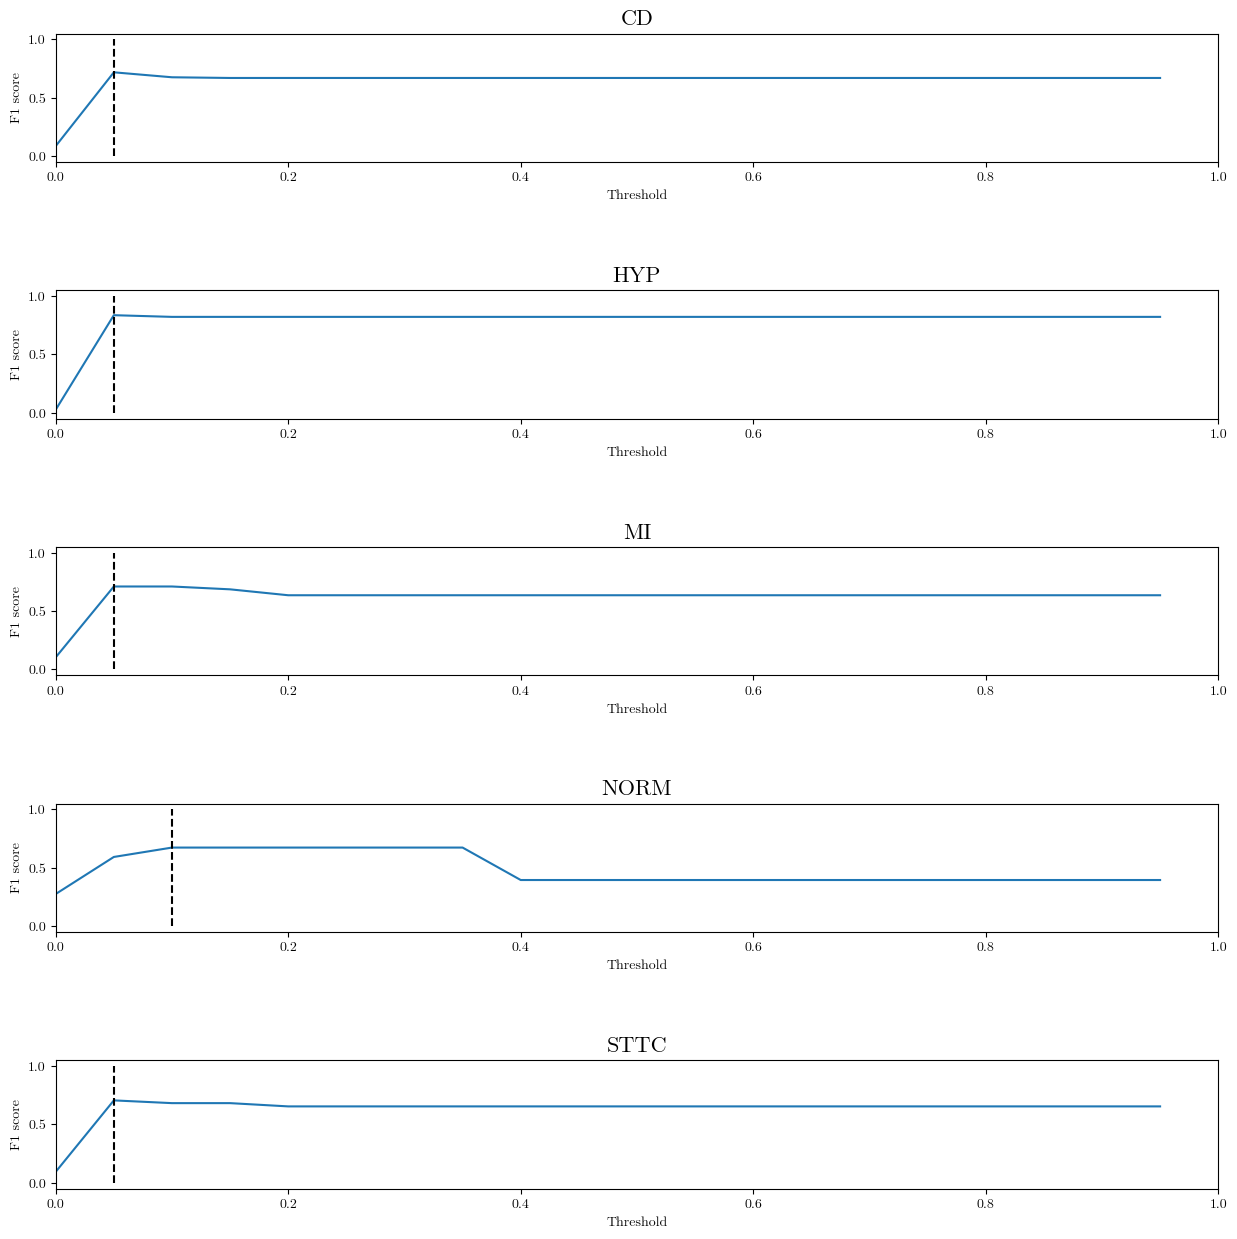

In [8]:
from scripts.data_evaluation import plot_optimal_thresholds

optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_proba, directory_name="mlknn", save_plot=True
)

In [9]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="mlknn",
    file_name="model_evaluation.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,1.342,0.741,0.0,0.0,0.5


In [10]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="mlknn",
    file_name="model_evaluation_optimized.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,1.342,0.725,0.514,0.471,0.631


## Confusion matrix

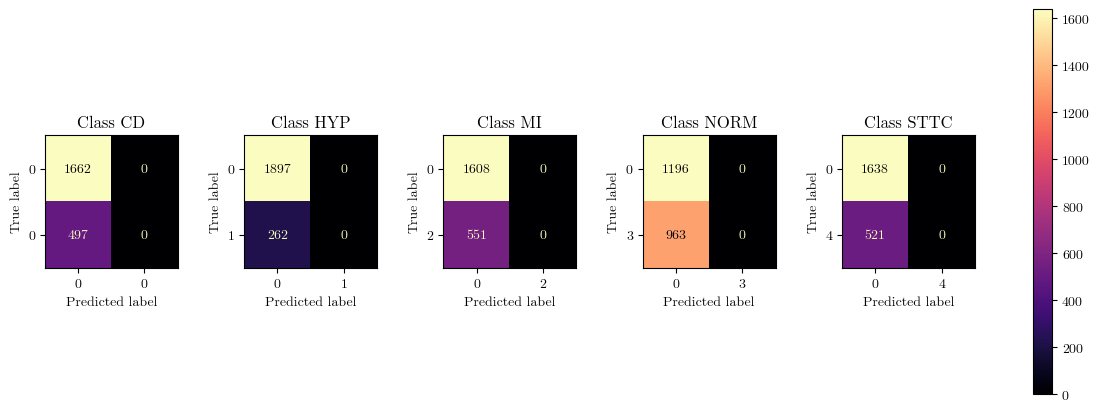

In [11]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="mlknn",
    file_name="confusion_matrix.png",
    save_plot=True,
)

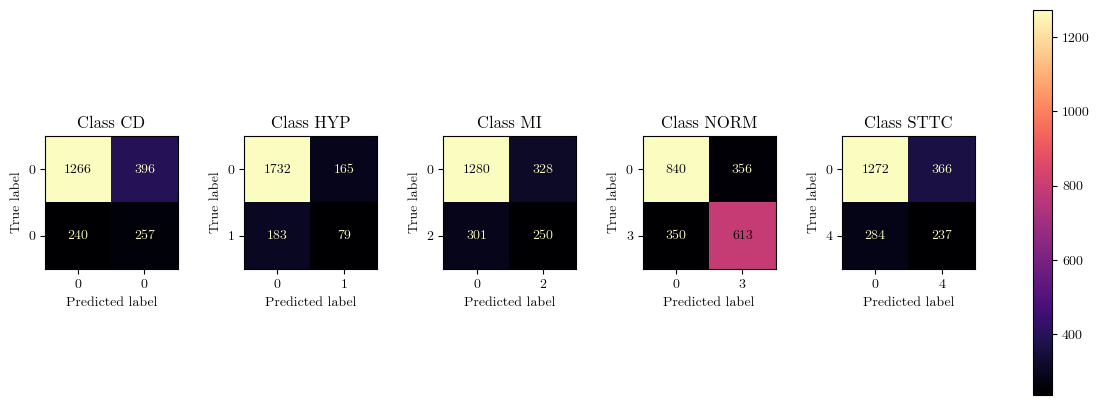

In [12]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="mlknn",
    file_name="confusion_matrix_optimized.png",
    save_plot=True,
)

## Classification report

In [13]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="mlknn",
    file_name="classification_report.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.0,0.0,0.0,497.0
HYP,0.0,0.0,0.0,262.0
MI,0.0,0.0,0.0,551.0
NORM,0.0,0.0,0.0,963.0
STTC,0.0,0.0,0.0,521.0
micro avg,0.0,0.0,0.0,2794.0
macro avg,0.0,0.0,0.0,2794.0
weighted avg,0.0,0.0,0.0,2794.0
samples avg,0.0,0.0,0.0,2794.0


In [14]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="mlknn",
    file_name="classification_report_optimized.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.394,0.517,0.447,497.0
HYP,0.324,0.302,0.312,262.0
MI,0.433,0.454,0.443,551.0
NORM,0.633,0.637,0.635,963.0
STTC,0.393,0.455,0.422,521.0
micro avg,0.471,0.514,0.492,2794.0
macro avg,0.435,0.473,0.452,2794.0
weighted avg,0.477,0.514,0.493,2794.0
samples avg,0.491,0.519,0.486,2794.0


## Show predictions on sample patients

In [18]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (mlknn_model.predict_proba(patient_ecg).toarray() > 0.5) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(
    f"saved_data/mlknn/sample_patients_predictions.csv"
)

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0


In [19]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (
        mlknn_model.predict_proba(patient_ecg).toarray() > optimal_thresholds
    ) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(
    f"saved_data/mlknn/sample_patients_predictions_optimized.csv"
)

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,1,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
